In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2, os

from sklearn.cluster import KMeans
import easyocr

In [2]:
%cd ..

/home/suetin/Projects/VSCode/ExciseProject/ExciseOCR


/home/suetin/Projects/VSCode/ExciseProject/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [21]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

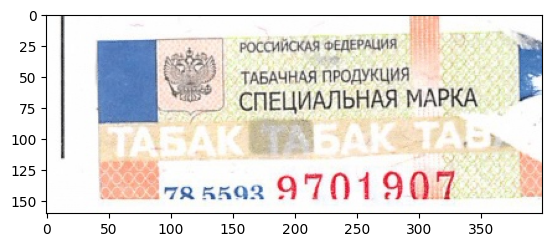

In [4]:
img = cv2.imread('data/splits/mark_0-0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE));

In [5]:
series_mask = cv2.inRange(np.float32(hsv),
    lowerb=np.array([105, 50, 0]),
    upperb=np.array([115, 360, 360])
)
number_mask = cv2.inRange(np.float32(hsv),
    lowerb=np.array([170, 50, 0]),
    upperb=np.array([180, 360, 360])
)
number_mask[:5, :5], series_mask[:5, :5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=uint8))

In [6]:
number_mask.shape, series_mask.shape

((400, 160), (400, 160))

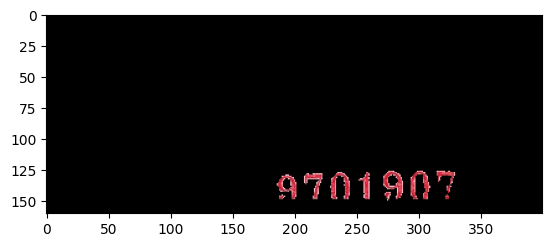

In [7]:
output = cv2.bitwise_and(hsv, hsv, mask=number_mask)
output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
output = cv2.rotate(output, cv2.ROTATE_90_COUNTERCLOCKWISE)    # RGB Photo 

plt.imshow(output);

In [8]:
new_out = output.copy()

In [9]:
contours = cv2.findContours(cv2.cvtColor(output, cv2.COLOR_RGB2GRAY), 
                            cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

323 145
190 145
274 143
193 129
193 131
210 128
258 127
235 127
315 126
299 126
276 126
278 129


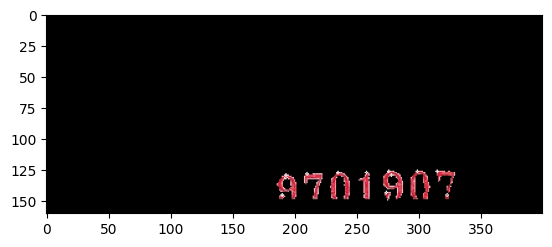

In [10]:
for conture in contours:
    # print(conture.shape)
    
    for x, y in conture[0]:
        print(x, y)
        new_out = cv2.circle(new_out, (x, y), radius=1, color=(255, 255, 255), thickness=1)
plt.imshow(new_out)

In [11]:
np.argmax(contours[7])

np.int64(58)

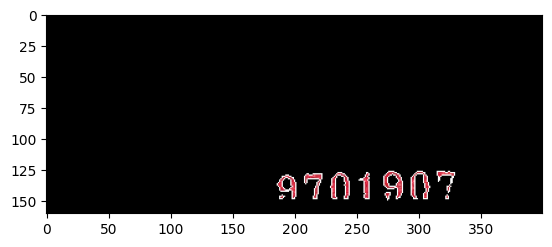

In [12]:
new_out = output.copy()


sel_countour=None
for countour in contours:
    sel_countour=countour
    new_out = cv2.drawContours(new_out, [sel_countour], 0, (255,255,255), 1)

plt.imshow(new_out)

In [13]:
reader.readtext(new_out)

[([[np.int32(181), np.int32(121)],
   [np.int32(337), np.int32(121)],
   [np.int32(337), np.int32(157)],
   [np.int32(181), np.int32(157)]],
  '9711 9 7',
  np.float64(0.23558973679269737))]

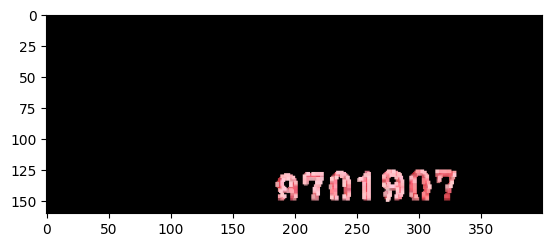

In [14]:
new_out = output.copy()

# Taking a matrix of size 5 as the kernel 
kernel = np.ones((3, 3), np.uint8) 

dilate = cv2.dilate(new_out, kernel, iterations=1) 
plt.imshow(dilate)

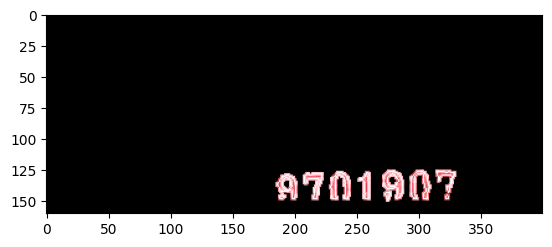

In [15]:
sel_countour=None
for countour in contours:
    sel_countour=countour
    new_out = cv2.drawContours(dilate, [sel_countour], 0, (255,255,255), 1)
plt.imshow(dilate)

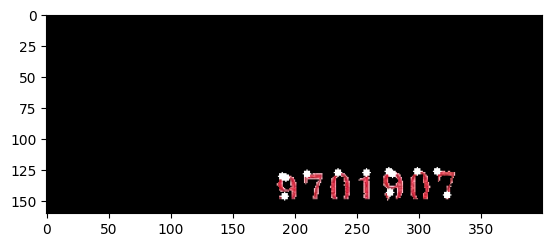

In [16]:
eps = 0.000005
new_out = output.copy()

sel_countour=None
for countour in contours:
    sel_countour=countour
    # calc arclentgh
    arclen = cv2.arcLength(sel_countour, True)

    # do approx
    epsilon = arclen * eps
    approx = cv2.approxPolyDP(sel_countour, epsilon, True)

    new_out = cv2.drawContours(new_out, approx, 0, (255,255,255), 5)

plt.imshow(new_out)

# Blur

In [17]:
cv2.blur(output, 5, 0)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'blur'
> Overload resolution failed:
>  - Can't parse 'ksize'. Input argument doesn't provide sequence protocol
>  - Can't parse 'ksize'. Input argument doesn't provide sequence protocol


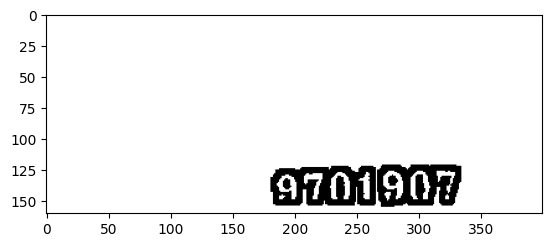

In [18]:
new_out = output

new_out = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)

th2 = cv2.adaptiveThreshold(new_out, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
plt.imshow(th2, 'gray')

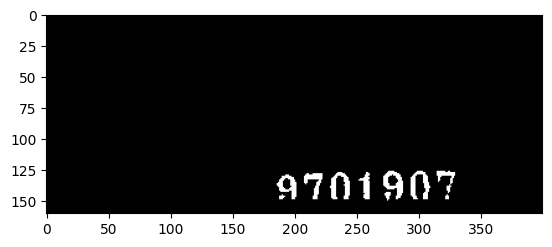

In [22]:
new_out = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
_, th1 = cv2.threshold(new_out,0,255,cv2.THRESH_BINARY)
plt.imshow(th1, 'gray')

In [23]:
reader.readtext(th1), reader.readtext(th2)

([([[np.int32(181), np.int32(121)],
    [np.int32(337), np.int32(121)],
    [np.int32(337), np.int32(157)],
    [np.int32(181), np.int32(157)]],
   '9701907',
   np.float64(0.9995824297755584))],
 [([[np.int32(175), np.int32(117)],
    [np.int32(339), np.int32(117)],
    [np.int32(339), 160],
    [np.int32(175), 160]],
   '970.907',
   np.float64(0.8986517591906134))])

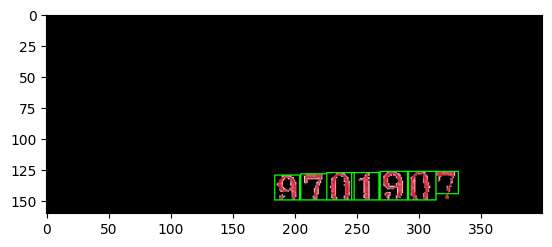

In [39]:
new_out = output

contours, heirs = cv2.findContours(cv2.cvtColor(output, cv2.COLOR_RGB2GRAY), 
                                cv2.RETR_TREE, 
                                cv2.CHAIN_APPROX_SIMPLE)
try:
    heirs = heirs[0]
except:
    heirs = []

for cnt, heir in zip(contours, heirs):
    _, _, _, outer_i = heir
    if outer_i >= 0:
        continue
    x, y, w, h = cv2.boundingRect(cnt)
    if not (16 <= h <= 64  and w <= 1.2*h):
        continue
    pad = max(h-w, 0)
    x, w = x - (pad // 2), w + pad
    new_out = cv2.rectangle(new_out, (x, y), (x+w, y+h), (0, 255, 0))

plt.imshow(new_out)